# **Данные**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import itertools
from scipy import linalg
import matplotlib as mpl
from sklearn import mixture
from scipy.stats import norm, multivariate_normal
from scipy.integrate import quad

In [2]:
data = pd.read_excel('euro_dollar.xlsx')
data = data.sort_values(by = ['curs_euro'])
data.head()

,date,curs_dollar,curs_euro,cum_dollar,cum_euro
3809,2014-12-18,-0.128638,-0.142679,1.232742,1.556321
5605,2022-04-07,-0.079885,-0.084087,1.482782,1.517790
3811,2014-12-20,-0.071521,-0.074047,1.110268,1.406443
5595,2022-03-24,-0.071473,-0.071291,2.151096,2.210241
5638,2022-05-28,-0.051060,-0.070371,1.020191,0.915850


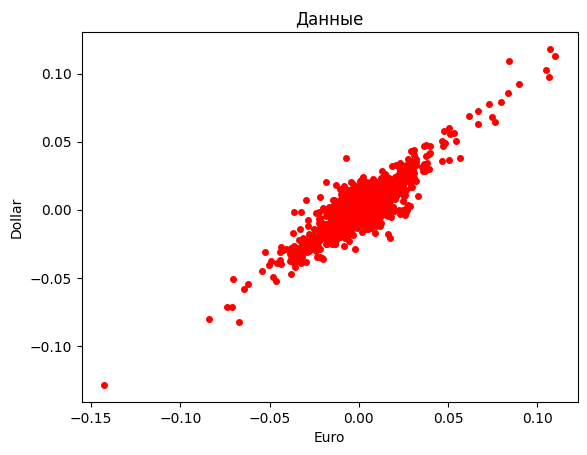

In [3]:
list_of_euro = list(data['curs_euro'])
list_of_dollar = list(data['curs_dollar'])
n_samples = data['curs_euro'].size
n_samples
plt.title('Данные')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(data['curs_euro'], data['curs_dollar'], 'ro', markersize=4)
#plt.legend(['С шумом', 'Истинный'])
plt.show()

In [4]:
np_data_dollar = np.array(data['curs_dollar']).reshape(-1, 1)
np_data_euro = np.array(data['curs_euro']).reshape(-1, 1)
np_data_euro

array([[-0.14267898],
       [-0.08408749],
       [-0.07404701],
       ...,
       [ 0.10664213],
       [ 0.10718334],
       [ 0.10994489]])

In [5]:
data_XY = np.concatenate([np_data_euro, np_data_dollar], axis = 1)
data_XY

array([[-0.14267898, -0.12863818],
       [-0.08408749, -0.07988462],
       [-0.07404701, -0.07152092],
       ...,
       [ 0.10664213,  0.09724502],
       [ 0.10718334,  0.11812002],
       [ 0.10994489,  0.11316388]])

# **Расчёт метода в двумерном случае**

## **Разделяем на смесь**

### **Выбор модели по BIC**

In [6]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 20),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(data_XY)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 20)},
             scoring=<function gmm_bic_score at 0x0000024674540860>)

In [7]:
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
58,2,full,-16384.039724
19,1,tied,-15785.578638
57,1,full,-15785.578638
59,3,full,-15521.351082
1,2,spherical,-15411.555564


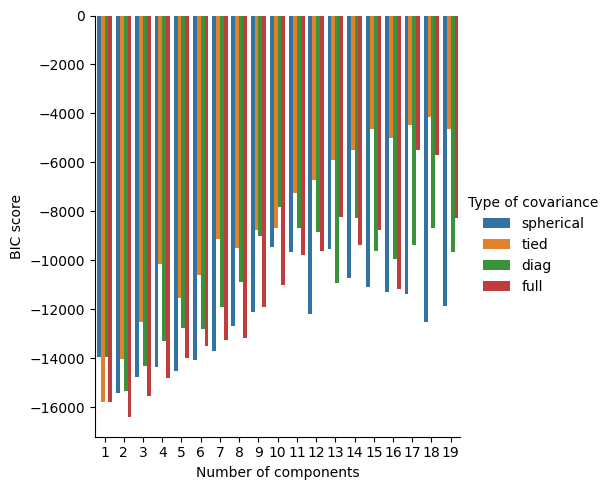

In [8]:
sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

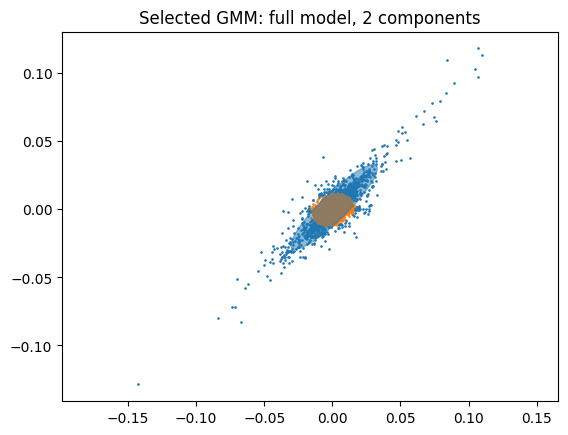

In [54]:
from matplotlib.patches import Ellipse
from scipy import linalg

color_iter = sns.color_palette("tab10", 2)[::-1]
Y_ = grid_search.predict(data_XY)

fig, ax = plt.subplots()

for i, (mean, cov, color) in enumerate(
    zip(
        grid_search.best_estimator_.means_,
        grid_search.best_estimator_.covariances_,
        color_iter,
    )
):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(data_XY[Y_ == i, 0], data_XY[Y_ == i, 1], 0.8, color=color)

    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ellipse = Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
    ellipse.set_clip_box(fig.bbox)
    ellipse.set_alpha(0.5)
    ax.add_artist(ellipse)

plt.title(
    f"Selected GMM: {grid_search.best_params_['covariance_type']} model, "
    f"{grid_search.best_params_['n_components']} components"
)
plt.axis("equal")
plt.show()

In [ ]:
best_2_dim_gmm = grid_search.best_estimator_
best_2_dim_gmm.weights_

0.8528516540604724

### **Строим регрессию на примере**

In [111]:
best_2_dim_gmm = GaussianMixture(n_components=12)
best_2_dim_gmm.fit(data_XY)
best_2_dim_gmm.weights_

array([0.09429303, 0.00229985, 0.01336928, 0.10854279, 0.01892638,
       0.04697637, 0.09565561, 0.00613459, 0.4374225 , 0.06835093,
       0.10067058, 0.0073581 ])

In [12]:
gmm = mixture.GaussianMixture(n_components=13)
gmm.fit(np_data_euro)

GaussianMixture(n_components=13)

In [93]:
a = 0
a_weights = gmm.predict_proba(np.array(a).reshape(-1, 1))
a_s_proba = norm.pdf(a, gmm.means_.reshape(1, -1), gmm.covariances_.reshape(1, -1) ** 0.5)
p_a = (a_s_proba * a_weights).sum()
a_weights, a_s_proba, p_a

(array([[9.58713511e-03, 8.12259623e-02, 1.68289516e-08, 3.23996433e-09,
         4.85375415e-08, 3.20873217e-01, 2.80879093e-08, 1.68363590e-08,
         9.11375304e-06, 5.87191223e-01, 1.04190894e-03, 7.13269273e-05,
         0.00000000e+00]]),
 array([[6.78480831e+00, 3.94513666e+01, 5.68212904e-04, 2.38999466e-05,
         9.26061996e-04, 1.05625375e+02, 1.34290387e-04, 6.36634050e-04,
         3.71763294e-02, 1.57960291e+02, 9.96792677e-01, 1.01043450e-01,
         0.00000000e+00]]),
 129.9158181277788)

In [ ]:
a = -0.136
y = -240000
p_a_y = 0
for i in range(best_2_dim_gmm.means_.shape[1]):
    p_a_y += multivariate_normal.pdf([a, y], best_2_dim_gmm.means_[i], best_2_dim_gmm.covariances_[i]) * best_2_dim_gmm.weights_[i]

p_a_y * y


-0.0

In [127]:
def cur_pdf_2_dim_dot_y (y, a):
    p_a_y = 0
    for i in range(best_2_dim_gmm.means_.shape[0]):
        p_a_y += multivariate_normal.pdf([a, y], best_2_dim_gmm.means_[i], best_2_dim_gmm.covariances_[i]) * best_2_dim_gmm.weights_[i]

    return p_a_y * y

def cur_pdf_2_dim (y, a):
    p_a_y = 0
    for i in range(best_2_dim_gmm.means_.shape[0]):
        p_a_y += multivariate_normal.pdf([a, y], best_2_dim_gmm.means_[i], best_2_dim_gmm.covariances_[i]) * best_2_dim_gmm.weights_[i]

    return p_a_y

def cur_pdf_1_dim (a):
    a_s_proba = norm.pdf(a, gmm.means_.reshape(1, -1), gmm.covariances_.reshape(1, -1) ** 0.5)
    return (a_s_proba * gmm.weights_).sum()

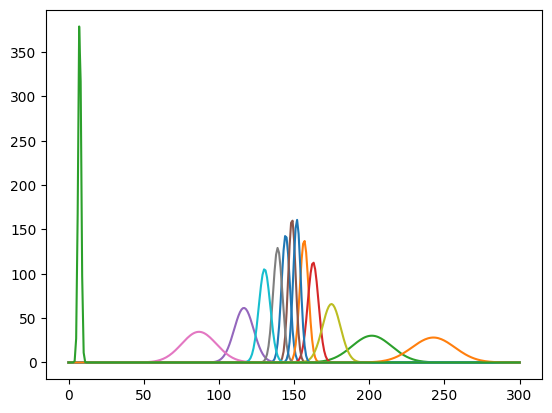

In [101]:
a_s_proba = norm.pdf(np.array([y_s]).reshape(-1, 1), gmm.means_.reshape(1, -1), gmm.covariances_.reshape(1, -1) ** 0.5)
plt.plot(a_s_proba)

In [118]:
def cur_pdf_2_dim_4 (y, a, p_a):
    p_a_y = []
    for i in range(best_2_dim_gmm.means_.shape[0]):
        p_a_y.append(multivariate_normal.pdf([a, y], best_2_dim_gmm.means_[i], best_2_dim_gmm.covariances_[i]) * best_2_dim_gmm.weights_[i] / p_a)

    return p_a_y

2

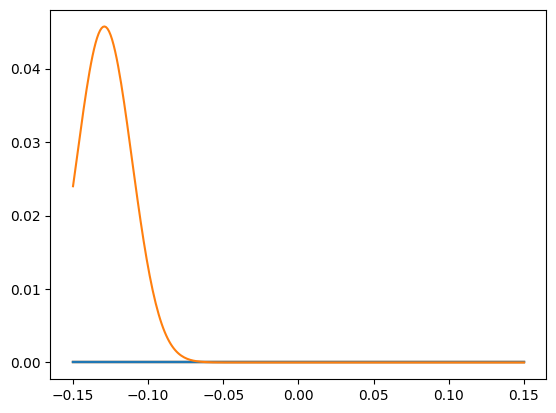

In [ ]:
y_s = [i/1000 for i in range(-150, 151)]
res = []
p_a = cur_pdf_1_dim(-0.05)
for y in y_s:
    # res.append(cur_pdf_1_dim(y))
    res.append(cur_pdf_2_dim_4(y, -0.15, p_a))

res = np.array(res)

plt.plot(y_s, res)

In [130]:
minimum = int(min(np_data_euro)[0] * 1000 - 1)
maximum = int(max(np_data_euro)[0] * 1000 + 1)
a_s = [i / 1000 for i in range(minimum, maximum)]
res = []
for a in a_s:
    p_a = cur_pdf_1_dim(a)
    if p_a != 0:
        # print(a, quad(cur_pdf_2_dim, -np.inf, np.inf, args=(a)), p_a )
        res.append(quad(cur_pdf_2_dim_dot_y, -np.inf, np.inf, args=(a))[0]/ quad(cur_pdf_2_dim, -np.inf, np.inf, args=(a))[0])
    else:
        res.append(0)

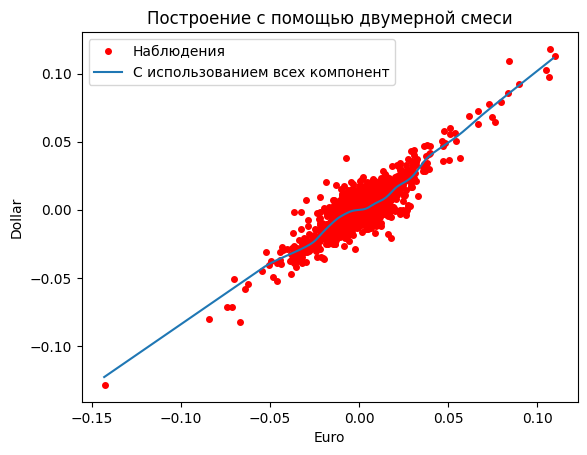

In [129]:
plt.title('Построение с помощью двумерной смеси')
plt.xlabel('Euro')
plt.ylabel('Dollar')
plt.plot(np_data_euro, np_data_dollar, 'ro', markersize=4)
plt.plot(a_s, res)
plt.legend(['Наблюдения', 'С использованием всех компонент'])
plt.show()